# MBTI - 16 Personalities classifier

# Introduction to the problem
Design and implement a model that given a "post" as input returns the most suited **Myers-Briggs personality type indicator (MBTI)**.

## What is a MBTI
The MBTI (Myers-Briggs Personality Type Indicator) divides everyone into **16 distinct personality** types across **4 axis**:

* Introversion (**I**) – Extroversion (**E**)
* Intuition (**N**) – Sensing (**S**)
* Thinking (**T**) – Feeling (**F**)
* Judging (**J**) – Perceiving (**P**)

This system is used in: *businesses, online, for fun, for research and lots more*.

# Google Colab setup

In [40]:
# Mounting Drive
from google.colab import drive
MOUNT_DIR = '/content/drive/'
drive.mount(MOUNT_DIR, force_remount=True)

# Some constants
USING_COLAB = True

Mounted at /content/drive/


In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
!pip install pandas
!pip install matplotlib

--2021-07-01 17:10:24--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-07-01 17:10:24--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-07-01 17:10:24 (38.4 MB/s) - written to stdout [1608/1608]

setup Cola

# Databricks setup

In [ ]:
USING_COLAB = False

# Importing Spark (and some other cool things)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import *

spark = sparknlp.start()
spark

# MBTI Dataset

## Downloading the dataset onto the cluster

I hosted the dataset on my [github](https://github.com/edu-rinaldi/MBTI-Predictor/blob/main/dataset/mbti_1.csv.zip), so that I and whoever want to train a different model can download it in an easier way.

### Databricks procedure

In [ ]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

Moving dataset to DBFS

In [ ]:
dbutils.fs.mv("file:/tmp/mbti_1.csv", "/FileStore/datasets/")
MBTI_DATASET_PATH = "dbfs:/FileStore/datasets/mbti_1.csv"

## Google Colab procedure

In [4]:
!wget -P /content/drive/MyDrive/datasets/ https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

--2021-07-01 07:52:56--  https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv [following]
--2021-07-01 07:52:56--  https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62856486 (60M) [text/plain]
Saving to: ‘/content/drive/MyDrive/datasets/mbti_1.csv.1’

mbti_1.csv.1        100%[===================>]  59.94M  63.6MB/s    in 0.9s    

2021-07-01 07:52:57 (63.6 MB/s) - ‘/content/drive/MyDrive/datasets

In [4]:
MBTI_DATASET_PATH = "/content/drive/MyDrive/datasets/mbti_1.csv"

## Initial dataset analysis

Now that we have downloaded the dataset, let's read it and analyze it

In [5]:
mbti_df = spark.read.load(MBTI_DATASET_PATH, format="csv", sep=",", inferSchema="true", header="true")
mbti_df.show()

+----+--------------------+
|type|               posts|
+----+--------------------+
|INFJ|'http://www.youtu...|
|ENTP|'I'm finding the ...|
|INTP|'Good one  _____ ...|
|INTJ|'Dear INTP,   I e...|
|ENTJ|'You're fired.|||...|
|INTJ|'18/37 @.@|||Scie...|
|INFJ|'No, I can't draw...|
|INTJ|'I tend to build ...|
|INFJ|I'm not sure, tha...|
|INTP|'https://www.yout...|
|INFJ|'One time my pare...|
|ENFJ|'https://www.yout...|
|INFJ|'Joe santagato - ...|
|INTJ|'Fair enough, if ...|
|INTP|'Basically this.....|
|INTP|'Your comment scr...|
|INFJ|'some of these bo...|
|INFP|'I think we do ag...|
|INFJ|'I fully believe ...|
|INFP|'That's normal, i...|
+----+--------------------+
only showing top 20 rows



### Description of the dataset
This **dataset** contains over **8600 rows of data**, and on each row contains:
* **Type**: 4 letter MBTI code/type
* **Posts**: A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

So after splitting each post we will have about **430k rows**. 

**Acknowledgements:**
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

In [6]:
print(f"The dataset is composed by {len(mbti_df.columns)} columns and {mbti_df.count()} entries/records")

The dataset is composed by 2 columns and 8675 entries/records


### Splitting posts by "|||" string and lowering "type"

In [7]:
#mbti_splitted_df = mbti_df.select(explode(split("posts", "\|\|\|")).alias("post"), lower("type").alias("type"))
mbti_splitted_df = mbti_df.select(regexp_replace(col('posts'), "\|\|\|", " ").alias("post"), lower("type").alias("type")).withColumn('num_post', lit(50))
mbti_splitted_df.show()

+--------------------+----+--------+
|                post|type|num_post|
+--------------------+----+--------+
|'http://www.youtu...|infj|      50|
|'I'm finding the ...|entp|      50|
|'Good one  _____ ...|intp|      50|
|'Dear INTP,   I e...|intj|      50|
|'You're fired. Th...|entj|      50|
|'18/37 @.@ Scienc...|intj|      50|
|'No, I can't draw...|infj|      50|
|'I tend to build ...|intj|      50|
|I'm not sure, tha...|infj|      50|
|'https://www.yout...|intp|      50|
|'One time my pare...|infj|      50|
|'https://www.yout...|enfj|      50|
|'Joe santagato - ...|infj|      50|
|'Fair enough, if ...|intj|      50|
|'Basically this.....|intp|      50|
|'Your comment scr...|intp|      50|
|'some of these bo...|infj|      50|
|'I think we do ag...|infp|      50|
|'I fully believe ...|infj|      50|
|'That's normal, i...|infp|      50|
+--------------------+----+--------+
only showing top 20 rows



## Are we dealing with a (Un)balanced Dataset ? 
One of the first things to check is the "density" of each class. 
A balanced dataset makes things easier..

### Counting records for each class

In [8]:
def count_class_instances(df, labelCol, toPandas=True):
  counted_df = df.select(labelCol).groupBy(labelCol).count().sort(labelCol)
  return counted_df.toPandas() if toPandas else counted_df

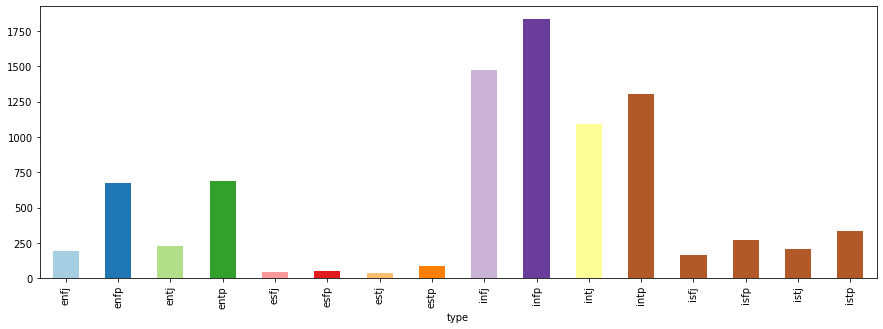

In [12]:
# Sorting by type because then we could compare this df with another
counted_mbti_types_pdf = count_class_instances(mbti_splitted_df, 'type')
counted_mbti_types_pdf.plot.bar(x='type', y='count', figsize=(15,5), legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

The first thing that unfortunately we can notice is that the dataset is very **unbalanced**.

The most predominant types are **INxx**, which correspond to introvert personalities; this make me think that on internet (especially on forums and/or social networks) the most predominant personality is the introvert one, so in real world application the model could deal more frequently with **INxx** types.

Another thing to notice is that **Sensing** (**xSxx**) personalities are the less frequents, and that is due to the fact that *Sensors* prefer learning information that they can tangibly apply to their lives. 

But to train in a balanced way our model we must find and then apply some strategies for handling this situation.

## Strategies for dealing with this unbalanced dataset
To deal with this situation we have different options:
1. **Undersampling**: remove instances from most frequent classes until the dataset is balanced
2. **Oversampling**: add synthetical instances of less frequent classes
3. **Collect more data**: we can collect more data of less frequent classes

In this notebook first and third strategies will be applied.

First we will undersample our current dataset so at the end It will be balanced, then using a Reddit scraper that I created, we can scrap new data and so we can create a **new dataset** (that will be presented in the next section) for increasing in a balanced way our "final" dataset size.

At first glance you might think of balancing the dataset only by adding new instances taking them from the new dataset but this could lead to several problems.

The two datasets that we are going to "merge" contain data collected from different "environments" (*PersonalityCafe* for the first one, *Reddit* for the second one), so adding the new data only on the less frequent classes can create differences that the model could interpret and use for classification (wrong, because they are not differences given by the class of the instance, but rather by the environment from which the data were collected)

### Additional strategy: divide type in 4 indicators
Dividing type in 4 indicator ("I/E", "N/S", "T/F", "P/J") brings us different benefits:
1. We can create 4 different models (one for each type indicator), so each model could be optimized for its own target (its own type indicator)
2. We can have 4 different datasets, each one with its own different data. For example in the original dataset if we undersample "INTP" instances because of the N value for "N/S" type indicator, we will undersample also information about the other 3 type indicators values

So the idea is to have at the end 4 different Binary Classifier, and then we can "merge" their results for the "final result"

In [9]:
def split_type(df, typeCol='type', withDrop=False):
  indicators = ['ie', 'ns', 'tf', 'pj']
  splitted_type_df = df
  for i, ind in enumerate(indicators):
    splitted_type_df = splitted_type_df.withColumn(ind, substring(typeCol, i+1, 1))
  if withDrop:
    splitted_type_df = splitted_type_df.drop(typeCol) 
  return splitted_type_df, indicators

In [10]:
mbti_type_splitted_df, indicators = split_type(mbti_splitted_df, withDrop=True)
mbti_type_splitted_df = mbti_type_splitted_df.cache()
mbti_type_splitted_df.show()

+--------------------+--------+---+---+---+---+
|                post|num_post| ie| ns| tf| pj|
+--------------------+--------+---+---+---+---+
|'http://www.youtu...|      50|  i|  n|  f|  j|
|'I'm finding the ...|      50|  e|  n|  t|  p|
|'Good one  _____ ...|      50|  i|  n|  t|  p|
|'Dear INTP,   I e...|      50|  i|  n|  t|  j|
|'You're fired. Th...|      50|  e|  n|  t|  j|
|'18/37 @.@ Scienc...|      50|  i|  n|  t|  j|
|'No, I can't draw...|      50|  i|  n|  f|  j|
|'I tend to build ...|      50|  i|  n|  t|  j|
|I'm not sure, tha...|      50|  i|  n|  f|  j|
|'https://www.yout...|      50|  i|  n|  t|  p|
|'One time my pare...|      50|  i|  n|  f|  j|
|'https://www.yout...|      50|  e|  n|  f|  j|
|'Joe santagato - ...|      50|  i|  n|  f|  j|
|'Fair enough, if ...|      50|  i|  n|  t|  j|
|'Basically this.....|      50|  i|  n|  t|  p|
|'Your comment scr...|      50|  i|  n|  t|  p|
|'some of these bo...|      50|  i|  n|  f|  j|
|'I think we do ag...|      50|  i|  n| 

### Single type indicator analysis

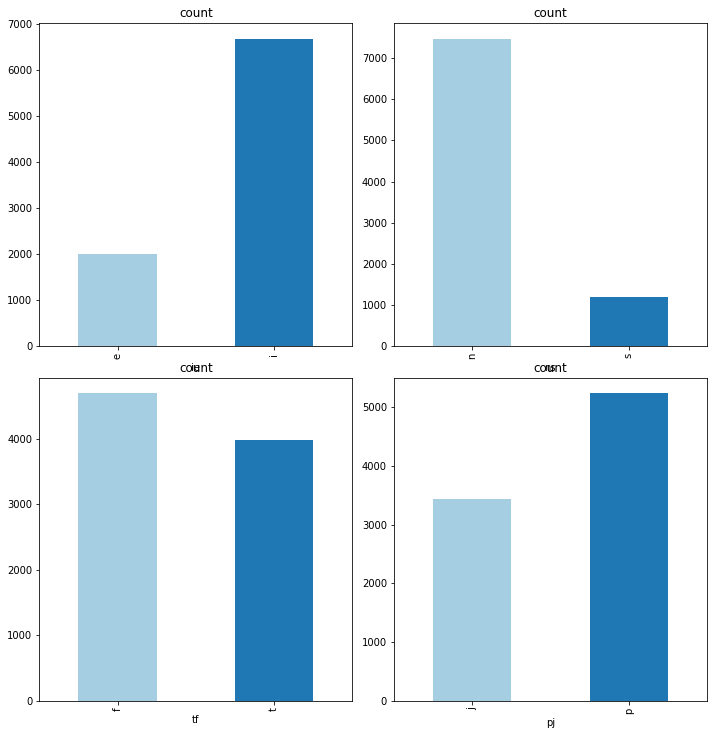

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

axes_idx = {'ie': (0,0), 'ns':(0,1), 'tf':(1,0), 'pj':(1,1)}
for ind in indicators:
  count_class_instances(mbti_type_splitted_df, ind).plot.bar(ax=axes[axes_idx[ind]],\
                                                             subplots=True,\
                                                             x=ind,\
                                                             y='count',\
                                                             legend=False,\
                                                             color=plt.cm.Paired(np.arange(2)))

As we said before the two most unbalanced type indicators are: **"I/E"** and **"N/S"**

# Reddit dataset

It's a **JSONL** dataset containing on each row:
* **Type**: as the MBTI dataset
* **Post**: w.r.t MBTI dataset each line contain a single post

Data has been collected on Reddit using a scraper created by me (code available [here](https://github.com/edu-rinaldi/MBTI-Predictor/tree/main/scraper)).
First thing I collected a list of users (and their respective personality) in 17 subreddits about MBTI ("r/mbti", "r/infp", ...); the personality information is given by a badge that is assigned to the user (and I scraped).

Then, I've scraped the most recent posts of each user (max. 100 for each user) on the **ENTIRE** Reddit platform, so I scraped also posts not related to MBTI.
At the end for each post I assigned the badge (so the personality) related to the author.

## Downloading the dataset

### Databricks procedure

In [ ]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz;
tar xvzf /tmp/reddit_mbti.tar.gz -C /tmp/

Move it to DBFS

In [ ]:
# Move it to DBFS
dbutils.fs.mv("file:/tmp/reddit_mbti.parquet", "/FileStore/datasets/")
REDDIT_DATASET_PATH = "dbfs:/FileStore/datasets/reddit_mbti.parquet"

## Google Colab procedure

In [16]:
!wget -P /content/drive/MyDrive/datasets/ https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz
!tar xvzf /content/drive/MyDrive/datasets/reddit_mbti.tar.gz -C /content/drive/MyDrive/datasets/
!rm /content/drive/MyDrive/datasets/reddit_mbti.tar.gz -r

--2021-07-01 07:54:34--  https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/reddit_mbti.tar.gz [following]
--2021-07-01 07:54:34--  https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/reddit_mbti.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58116681 (55M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/datasets/reddit_mbti.tar.gz’

reddit_mbti.tar.gz  100%[===================>]  55.42M  81.3MB/s    in 0.7s    

2021-07-01 07:54:36 (8

In [11]:
REDDIT_DATASET_PATH = "/content/drive/MyDrive/datasets/reddit_mbti.parquet"

### Loading dataset into a Spark dataframe

In [12]:
#reddit_df = spark.read.json("dbfs:/FileStore/datasets/reddit_mbti.json")
reddit_df = spark.read.load(REDDIT_DATASET_PATH)
print(f"The dataset is composed by {len(reddit_df.columns)} columns and {reddit_df.count()} entries/records")
# reddit_grouped_df = reddit_df.groupBy('redditor_id', 'type', 'text_type').agg(count(col('redditor_id')).alias('num_post'), concat_ws(" ||| ", collect_list("post")).alias('post')).where(col('num_post') >= 50).cache()

The dataset is composed by 5 columns and 5754 entries/records


## Analysis

### Counting records for each type

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f23ba9fa6d0>],
      dtype=object)

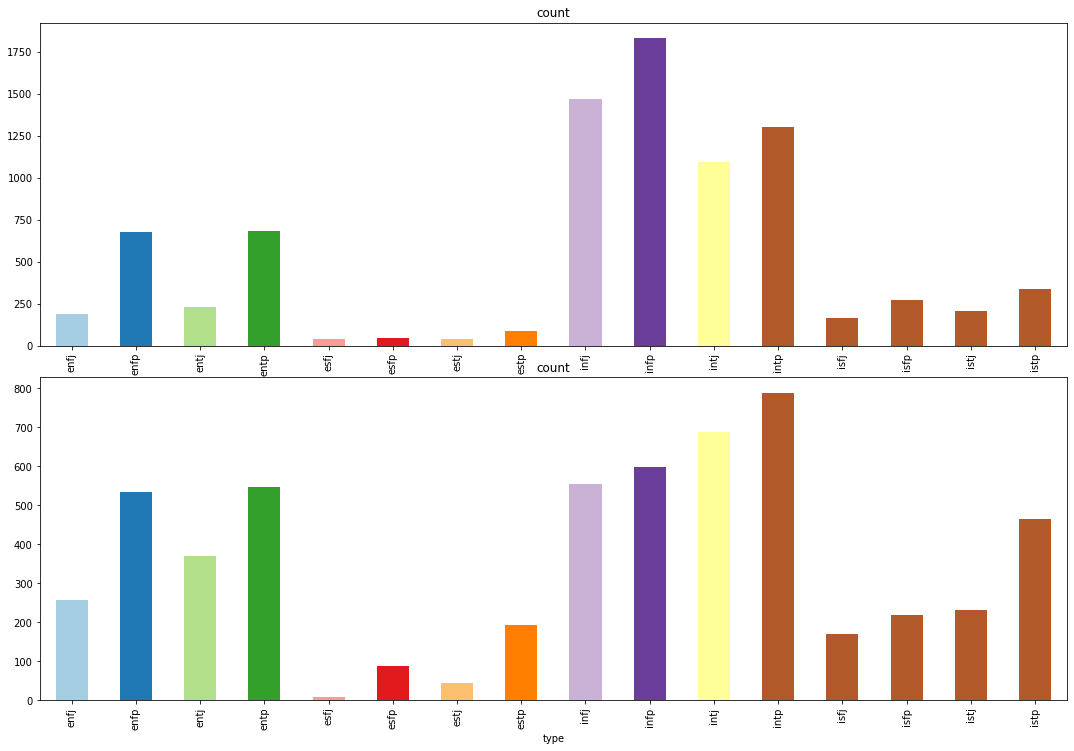

In [19]:
counted_reddit_types_pdf = count_class_instances(reddit_df, 'type')

fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(15,10))
fig.tight_layout()

counted_mbti_types_pdf.plot.bar(ax=axes[0], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))
counted_reddit_types_pdf.plot.bar(ax=axes[1], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_reddit_types_pdf))))

On top we have the MBTI dataset, below we have the Reddit dataset.
As we can see the type distribution is very similar.

### Split type in 4 indicators

In [13]:
reddit_splitted_df, _ = split_type(reddit_df, withDrop=True)
reddit_splitted_df.show()

+-----------+---------+--------+--------------------+---+---+---+---+
|redditor_id|text_type|num_post|                post| ie| ns| tf| pj|
+-----------+---------+--------+--------------------+---+---+---+---+
|     101tuq|  comment|     100|Arin can fred |||...|  i|  n|  t|  j|
|     114fsa|  comment|     100|  ||| "Are you ki...|  i|  s|  t|  p|
|     114fsa|    title|      67|Spin that wheel |...|  i|  s|  t|  p|
|     114mu2|  comment|     100|Die nerven sich m...|  e|  n|  f|  p|
|     116d0h|  comment|     100|I admire your abi...|  e|  n|  f|  j|
|   11dxh05w|  comment|     100|👏 but try not to...|  i|  n|  f|  p|
|     11ghzk|  comment|     100|1: At least 4 stu...|  i|  s|  f|  j|
|     11usaf|  comment|     100|She’s clearly not...|  i|  s|  t|  p|
|     11wn2y|  comment|     100|Yeah, I don’t rea...|  i|  n|  f|  p|
|     12bccu|    title|      50|GAME ENGINE DEVEL...|  e|  n|  t|  p|
|     12j670|  comment|     100|and pink diamond ...|  e|  n|  t|  p|
|     12ryws|  commen

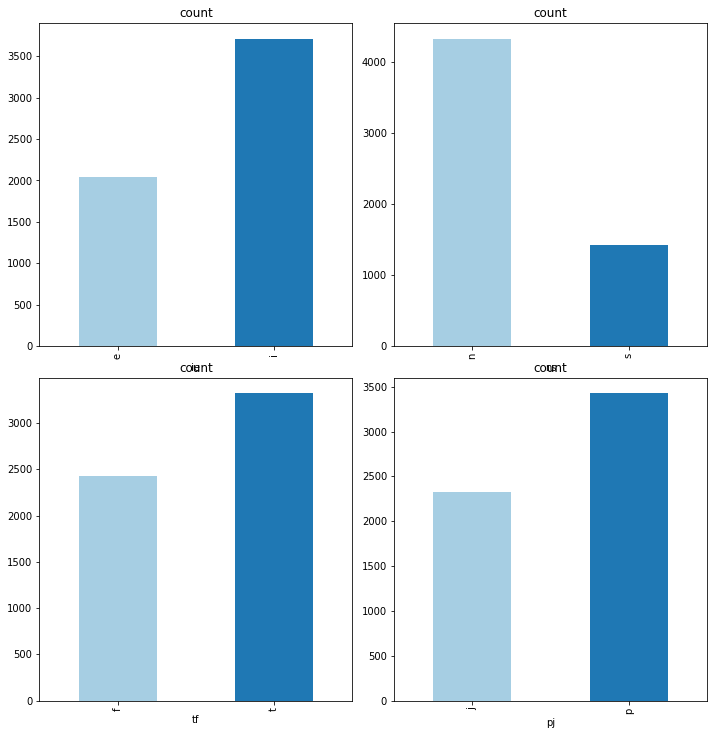

In [21]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

axes_idx = {'ie': (0,0), 'ns':(0,1), 'tf':(1,0), 'pj':(1,1)}
for ind in indicators:
  count_class_instances(reddit_splitted_df, ind).plot.bar(ax=axes[axes_idx[ind]],\
                                                             subplots=True,\
                                                             x=ind,\
                                                             y='count',\
                                                             legend=False,\
                                                             color=plt.cm.Paired(np.arange(2)))

# Data/Text cleaning
Before creating a balanced dataset let's first clean them (some records will be removed, so it's better to balance after)

In [14]:
def extract_extra_features(df, postCol='post', termsCol='terms', numPostCol='num_post', removeEmpty=True):
  
  normalize_column = lambda c: 100*c/(0.3*col(numPostCol)+0.7*size(termsCol))
  normalize_length = lambda c: c/col(numPostCol)
  # number of urls
  num_url_df = df.withColumn('url_num', normalize_column(size(split(col(postCol), r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')) - 1))
  # number of emoticons
  num_emoticon_df = num_url_df.withColumn('emoji_num', normalize_column(size(split(col(postCol), r':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)')) - 1))
  # number of emojis
  # num_emoji_df = num_emoticon_df
  
  # number of '?'
  num_qm_df = num_emoticon_df.withColumn('qm_num', normalize_column(size(split(col(postCol), r'\?')) - 1))
  
  # sentence length
  sentence_length_df = num_qm_df.withColumn('length', normalize_length(size(termsCol)))
  
  if removeEmpty:
    return sentence_length_df.where(col('length') > 8/col(numPostCol))
  else:
    return sentence_length_df

## Cleaning MBTI dataset

In [15]:
union_df = reddit_splitted_df.select('post', 'num_post', 'ie', 'ns', 'tf', 'pj').union(mbti_type_splitted_df)
print(f"The dataset is composed by {len(union_df.columns)} columns and {union_df.count()} entries/records")
union_df.show()

The dataset is composed by 6 columns and 14429 entries/records
+--------------------+--------+---+---+---+---+
|                post|num_post| ie| ns| tf| pj|
+--------------------+--------+---+---+---+---+
|Arin can fred |||...|     100|  i|  n|  t|  j|
|  ||| "Are you ki...|     100|  i|  s|  t|  p|
|Spin that wheel |...|      67|  i|  s|  t|  p|
|Die nerven sich m...|     100|  e|  n|  f|  p|
|I admire your abi...|     100|  e|  n|  f|  j|
|👏 but try not to...|     100|  i|  n|  f|  p|
|1: At least 4 stu...|     100|  i|  s|  f|  j|
|She’s clearly not...|     100|  i|  s|  t|  p|
|Yeah, I don’t rea...|     100|  i|  n|  f|  p|
|GAME ENGINE DEVEL...|      50|  e|  n|  t|  p|
|and pink diamond ...|     100|  e|  n|  t|  p|
|"Just a pam looki...|     100|  e|  n|  t|  p|
|Not gonna lie, I ...|     100|  e|  s|  f|  p|
|What the fuck is ...|     100|  e|  s|  f|  p|
|Please supply mor...|     100|  e|  n|  t|  j|
|Why can't you guy...|     100|  e|  n|  t|  j|
|Radio killed the ...|    

In [16]:
def text_cleaning_pipeline(df, inputCol='post', outputCol='terms'):
  
  normalization_patterns = [
    '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', # url
    ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)', #emoticons
    '(\[removed\])', # removed reddit instance
    '[^A-Za-z]',
    '([ieIE])([nsNS])([tfTF])([pjPJ])', # remove mbti words
    '([a-z])\1{2,}[\s|\w]*' # remove consecutive single chars
  ]
  
  documentAssembler = DocumentAssembler()\
    .setInputCol(inputCol)\
    .setOutputCol('document')\
    #.setCleanupMode("shrink_full")
  
  tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
  
  normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized')\
    .setLowercase(True)\
    .setCleanupPatterns(normalization_patterns) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
  
  lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \
    #.setDictionary("dbfs:/bdc-2020-21/lemmatizer_files/lemmas.txt", value_delimiter ="\t", key_delimiter = "->")
  
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_en', 'en')\
      .setInputCols('lemma')\
      .setOutputCol('cleanLemma_1')\
      .setCaseSensitive(False)

  second_stopwords_cleaner = StopWordsCleaner()\
      .setInputCols('cleanLemma_1')\
      .setOutputCol('cleanLemma_2')\
      .setCaseSensitive(False)\
      .setStopWords(['isnt', 'dont', 'ive', 'im', 'arent', 'doesnt', 'havent', 'youre'])
  
  finisher = Finisher() \
    .setInputCols(['cleanLemma_2']) \
    .setOutputCols([outputCol]) \
    .setIncludeMetadata(False)
  
  pipeline_stages = [
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    second_stopwords_cleaner,
    finisher
  ]
  
  # sentence_length_df = pipeline_model.transform(df).withColumn('length', size('terms_stemmed')).cache()
  return Pipeline(stages=pipeline_stages).fit(df)

In [17]:
# train/test splitting
train_df, test_df = union_df.randomSplit([0.7, 0.3])
train_df = train_df
test_df = test_df

# tc_pipeline will be used for cleaning and splitting in terms posts
tc_pipeline = text_cleaning_pipeline(train_df)
clean_train_df = tc_pipeline.transform(train_df).cache()
clean_test_df = tc_pipeline.transform(test_df).cache()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [18]:
PRETRAINED_MODELS_PATH = '/content/drive/MyDrive/PretrainedModels/' if USING_COLAB else 'dbfs:/FileStore/PretrainedModels/'

def save_model(model, name):
  import datetime
  path = PRETRAINED_MODELS_PATH + name + f'_{datetime.datetime.now().strftime("%Y%m%d%H%M")}'
  print(f'Saving the model at this path: {path}')
  model.write().overwrite().save(path)

In [19]:
def feature_extraction_pipeline(df,
                                termsCol='terms',
                                outputCVFeaturesCol='cv_features',
                                outputIdfFeaturesCol='idf_features',
                                outputPCAFeaturesCol='pca_features',
                                pcaK=100,
                                cvMinDF=0.01,
                                indicatorsCols=['ie','ns','tf','pj'],
                                pretrainedName='',
                                saveModel=False):
  from pyspark.ml.feature import CountVectorizer, IDF, PCA, StringIndexer
  from pyspark.ml import Pipeline, PipelineModel
  
  if pretrainedName != '':
    pipeline_model = PipelineModel.load(PRETRAINED_MODELS_PATH+pretrainedName)
    print(f'Using a pretrained pipeline model saved at this path: {pretrainedName}')
  else:
    print('Creating a new pipeline model')
    cv = CountVectorizer(inputCol=termsCol, outputCol=outputCVFeaturesCol, minDF=cvMinDF)
    idf = IDF(inputCol=outputCVFeaturesCol, outputCol=outputIdfFeaturesCol)
    pca = PCA(k=100, inputCol=outputIdfFeaturesCol, outputCol=outputPCAFeaturesCol)
    string_indexers = [StringIndexer(inputCol=ind, outputCol=f"idx_{ind}") for ind in indicators]
    stages = [cv, idf] + ([pca] if pcaK > 0 else []) + string_indexers
    pipeline_model = Pipeline(stages=stages).fit(df)
    print('Fitting the new pipeline model')
  
  if saveModel:
    tmp_pca_str = f'pca{pcaK}_' if pcaK > 0 else ''
    save_path = f'cv{cvMinDF}_idf_{tmp_pca_str}'
    save_model(pipeline_model, save_path)
  
  return pipeline_model

In [21]:
fe_pipeline = feature_extraction_pipeline(clean_train_df, pretrainedName='cv0.01_idf_pca100_202106291739')
labels = [fe_pipeline.stages[3+i].labels for i, ind in enumerate(indicators)]

fe_pipeline.transform(clean_train_df).show()

Using a pretrained pipeline model saved at this path: cv0.01_idf_pca100_202106291739
+--------------------+--------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post|num_post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+--------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|  ||| "Are you ki...|     100|  i|  s|  t|  p|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0117535358123...|   0.0|   1.0|   0.0|   0.0|
| "riding things" ...|      79|  i|  s|  t|  p|[ride, thing, lma...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00350266780176...|   0.0|   1.0|   0.0|   0.0|
| Not that chick w...|     100|  e|  n|  f|  p|[chick, hold, han...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00

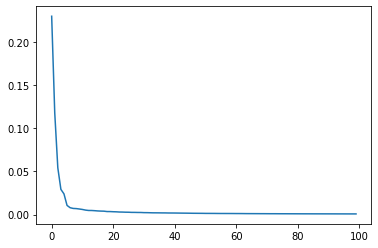

In [22]:
# Explained Variance by PCA (from ~20 not so much variance)
plt.plot(fe_pipeline.stages[2].explainedVariance)

In [28]:
final_train_df = fe_pipeline.transform(clean_train_df).cache()
final_test_df = fe_pipeline.transform(clean_test_df).cache()

In [29]:
def ml_pipeline(df,
                trainingAlgorithm,
                paramGrid,
                evaluator,
                labels,
                kFold=4,
                featuresCol='features',
                indexedTargetCol='idx_target',
                predictionCol='prediction',
                rawPredictionCol='rawPrediction',
                labeledPredictionCol='labeled_prediction'):
  
  from pyspark.ml.feature import IndexToString
  from pyspark.ml.tuning import CrossValidator
  from pyspark.ml import Pipeline
  
  trainingAlgorithm = trainingAlgorithm.setFeaturesCol(featuresCol).setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setRawPredictionCol(rawPredictionCol)
  
  idx2str = IndexToString(inputCol=predictionCol,
                          outputCol=labeledPredictionCol,
                          labels=labels)
  
  ml_pipeline = Pipeline(stages=[trainingAlgorithm, idx2str])
  
  evaluator = evaluator.setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setMetricName('f1')
  
  return CrossValidator(estimator=ml_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=kFold, collectSubModels=True).fit(df)

In [32]:
def nb_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    pretrainedNames={},
                    saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder
  from pyspark.ml.classification import NaiveBayes
  from pyspark.ml.tuning import CrossValidatorModel
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  nb_based_models = dict()
  for i, ind in enumerate(allowed_indicators):
    if ind in pretrainedNames:
      print(f'Loading pretrained model for {ind} named \'{pretrainedNames[ind]}\'\n')
      nb_based_models[ind] = CrossValidatorModel.load(PRETRAINED_MODELS_PATH + pretrainedNames[ind])
    else:
      print(f'Finding best NB model for {ind} type indicator..\n')
      nb_classifier = NaiveBayes()
      nb_param_grid = ParamGridBuilder().addGrid(nb_classifier.modelType, ['multinomial', 'gaussian']).build()
      nb_evaluator = MulticlassClassificationEvaluator()
      nb_based_models[ind] = ml_pipeline(final_train_df,
                                        nb_classifier,
                                        nb_param_grid,
                                        nb_evaluator,
                                        labels[i],
                                        featuresCol=featuresCol,
                                        indexedTargetCol=f'idx_{ind}',
                                        kFold=kFold)

  # best models' score
  for ind in indicators:
    best_model = nb_based_models[ind].bestModel
    score = nb_based_models[ind].getEvaluator().evaluate(best_model.transform(final_test_df))
    
    if saveModel:
      import builtins
      save_model(nb_based_models[ind], f'cv_nb_{ind}_{builtins.round(score, 3)}_modelType{best_model.stages[0].getModelType()}')

    print(f'Best nb {ind} model has type {best_model.stages[0].getModelType()}\nwith f1 = {score}\n')

  return nb_based_models

In [62]:
nb_pretrained_names = {
    'ie': 'cv_nb_ie_0.69_modelTypemultinomial_202107011646',
    'ns': 'cv_nb_ns_0.745_modelTypemultinomial_202107011646',
    'tf': 'cv_nb_tf_0.699_modelTypemultinomial_202107011647',
    'pj': 'cv_nb_pj_0.625_modelTypemultinomial_202107011647'
    }
nb_model_tuning(final_train_df, labels, featuresCol='idf_features', pretrainedNames=nb_pretrained_names, saveModel=False)

Loading pretrained model for ie named 'cv_nb_ie_0.69_modelTypemultinomial_202107011646'

Loading pretrained model for ns named 'cv_nb_ns_0.745_modelTypemultinomial_202107011646'

Loading pretrained model for tf named 'cv_nb_tf_0.699_modelTypemultinomial_202107011647'

Loading pretrained model for pj named 'cv_nb_pj_0.625_modelTypemultinomial_202107011647'

Best nb ie model has type multinomial
with f1 = 0.6895359987394507

Best nb ns model has type multinomial
with f1 = 0.744640020160779

Best nb tf model has type multinomial
with f1 = 0.6989501721348172

Best nb pj model has type multinomial
with f1 = 0.624789111252808



{'ie': CrossValidatorModel_72f0ca76c6c8,
 'ns': CrossValidatorModel_029099d3a8a0,
 'pj': CrossValidatorModel_7466ae90a63d,
 'tf': CrossValidatorModel_b19fd157625e}

In [42]:
def svc_model_tuning(df,
                     labels,
                     kFold=4,
                     allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                     featuresCol='features',
                     pretrainedNames={},
                     saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder
  from pyspark.ml.classification import LinearSVC
  from pyspark.ml.tuning import CrossValidatorModel
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  svc_based_models = dict()
  for i, ind in enumerate(allowed_indicators):
    if ind in pretrainedNames:
      print(f'Loading pretrained model for {ind} named \'{pretrainedNames[ind]}\'\n')
      svc_based_models[ind] = CrossValidatorModel.load(PRETRAINED_MODELS_PATH + pretrainedNames[ind])
    else:
      print(f'Finding best SVC model for {ind} type indicator..\n')
      svc_classifier = LinearSVC()
      svc_param_grid = ParamGridBuilder().addGrid(svc_classifier.maxIter, [10, 100]) \
      .addGrid(svc_classifier.regParam, [1, 0.5, 0.1, 0.01, 0.001, 0.0001]).build()
      
      svc_evaluator = MulticlassClassificationEvaluator()
      svc_based_models[ind] = ml_pipeline(final_train_df,
                                        svc_classifier,
                                        svc_param_grid,
                                        svc_evaluator,
                                        labels[i],
                                        featuresCol=featuresCol,
                                        indexedTargetCol=f'idx_{ind}',
                                        kFold=kFold)

  # best models' score
  for ind in allowed_indicators:
    best_model = svc_based_models[ind].bestModel
    score = svc_based_models[ind].getEvaluator().evaluate(best_model.transform(final_test_df))
    
    if saveModel:
      import builtins
      save_model(svc_based_models[ind], f'cv_svc_{ind}_{builtins.round(score, 3)}_maxIter{best_model.stages[0].getMaxIter()}_regParam{best_model.stages[0].getRegParam()}')
    print(f'Best svc {ind} model has parameters:\n\t - maxIter: {best_model.stages[0].getMaxIter()}\n\t - regParam: {best_model.stages[0].getRegParam()}\nwith f1 = {score}\n')
  return svc_based_models

In [43]:
svc_pretrained_names = {
    'ie': 'cv_svc_ie_0.613_maxIter10_regParam0.001_202107011814',
    'ns': 'cv_svc_ns_0.732_maxIter10_regParam0.0001_202107011815',
    'tf': 'cv_svc_tf_0.725_maxIter100_regParam0.1_202107011816',
    'pj': 'cv_svc_pj_0.494_maxIter10_regParam0.0001_202107011817'
}
svc_model_tuning(final_train_df, labels, featuresCol='pca_features', pretrainedNames=svc_pretrained_names, saveModel=True)
# da fare domani mattina
# svc_model_tuning(final_train_df, labels, featuresCol='pca_features', saveModel=True, allowed_indicators=['pj'])

Loading pretrained model for pj named 'cv_svc_pj_0.494_maxIter10_regParam0.0001_202107011817'

Saving the model at this path: /content/drive/MyDrive/PretrainedModels/cv_svc_pj_0.494_maxIter10_regParam0.0001_202107011948
Best svc pj model has parameters:
	 - maxIter: 10
	 - regParam: 0.0001
with f1 = 0.4944383191301762



{'pj': CrossValidatorModel_bfde651504aa}

In [ ]:
def lr_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    pretrainedNames={},
                    saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder
  from pyspark.ml.classification import LogisticRegression
  from pyspark.ml.tuning import CrossValidatorModel
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  lr_based_models = dict()
  for i, ind in enumerate(allowed_indicators):
    if ind in pretrainedNames:
      print(f'Loading pretrained model for {ind} named \'{pretrainedNames[ind]}\'\n')
      lr_based_models[ind] = CrossValidatorModel.load(PRETRAINED_MODELS_PATH + pretrainedNames[ind])
    else:
      print(f'Finding best LR model for {ind} type indicator..\n')
      lr_classifier = LogisticRegression()
      lr_param_grid = ParamGridBuilder().addGrid(lr_classifier.maxIter, [10, 100]) \
      .addGrid(lr_classifier.regParam, [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]) \
      .addGrid(lr_classifier.elasticNetParam, [0.0, 0.5, 1.0]).build()
      
      lr_evaluator = MulticlassClassificationEvaluator()
      lr_based_models[ind] = ml_pipeline(final_train_df,
                                        lr_classifier,
                                        lr_param_grid,
                                        lr_evaluator,
                                        labels[i],
                                        featuresCol=featuresCol,
                                        indexedTargetCol=f'idx_{ind}',
                                        kFold=kFold)

  # best models' score
  for ind in allowed_indicators:
    best_model = lr_based_models[ind].bestModel
    score = lr_based_models[ind].getEvaluator().evaluate(best_model.transform(final_test_df))
    
    if saveModel:
      import builtins
      save_model(lr_based_models[ind], f'cv_lr_{ind}_{builtins.round(score, 3)}_maxIter{best_model.stages[0].getMaxIter()}_regParam{best_model.stages[0].getRegParam()}_elasticNetParam{best_model.stages[0].getElasticNetParam()}')
      
    print(f'Best LR {ind} model has parameters:\n\t - maxIter: {best_model.stages[0].getMaxIter()}\n\t - regParam: {best_model.stages[0].getRegParam()}\n\t - elasticNetParam: {best_model.stages[0].getElasticNetParam()}\nwith f1 = {score}')
  return lr_based_models

In [24]:
lr_model_tuning(final_train_df, labels, featuresCol='pca_features')

Finding best LR model for ie type indicator..

Finding best LR model for ns type indicator..

Finding best LR model for tf type indicator..

Finding best LR model for pj type indicator..

